# dAiv AI_Competition[2024]_ResNeXt101 for PyTorch

## Import Libraries

In [51]:
from os import path, mkdir, makedirs
import signal

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import GradScaler

import torchvision
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [ ]:
!nvidia-smi

In [53]:
# ** 모델 훈련하기 전에 CUDA DEVICES 선택하기 **
import os

# CUDA_VISIBLE_DEVICES를 설정하여 사용할 GPU를 지정
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# 장치를 CUDA로 설정(위에 지정된 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("INFO: Using device -", device)
print("Number of devices currently in use -", torch.cuda.device_count())

INFO: Using device - cpu
Number of devices currently in use - 0


## Load DataSets

In [54]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [55]:
IMG_SIZE = (512, 512)
IMG_NORM = dict(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # 이미지 리사이즈
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(**IMG_NORM)  # 정규화
])

In [56]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9866), Valid(3430), Test(3347)


## Data Augmentation

In [57]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [58]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer,
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random') # 추가적인 모델 과적합 방지를 위한 Random Erasing
    
])

In [59]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9866)


## DataLoader

In [60]:
# GPU가 여러 개인 경우 배치 크기를 더 크게 설정
if torch.cuda.device_count() > 1:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16

print("INFO: BATCH_SIZE -", BATCH_SIZE)

INFO: BATCH_SIZE - 16


## CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features
#### Clova AI Research, NAVER Corp. Clova AI Research, LINE Plus Corp. Yonsei University

## 
## Cutmix와 Mixup의 도입

<img src="./images/cutmix_mixup.png" alt="설명" width="1000" height="700"/>

In [61]:
# CutMix 함수 정의
def cutmix(x, y, alpha=1.0):
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.7)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = shuffled_x[:, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))

    return x, y, shuffled_y, lam

# 임의의 바운딩 박스 생성 함수
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [62]:
# Mixup 함수 정의
def mixup(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)

    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    mixed_x = lam * x + (1 - lam) * shuffled_x

    y_a, y_b = y, shuffled_y

    return mixed_x, y_a, y_b, lam

## WeightedRandomSampler

##### 훈련 데이터의 클래스별 데이터 불균형을 해결하기 위해 각 클래스의 샘플 수를 계산하고, 멀티프로세싱을 활용하여 클래스별 가중치를 생성한 후, 이 가중치를 기반으로 WeightedRandomSampler를 사용하여 균형 잡힌 샘플링을 수행함.

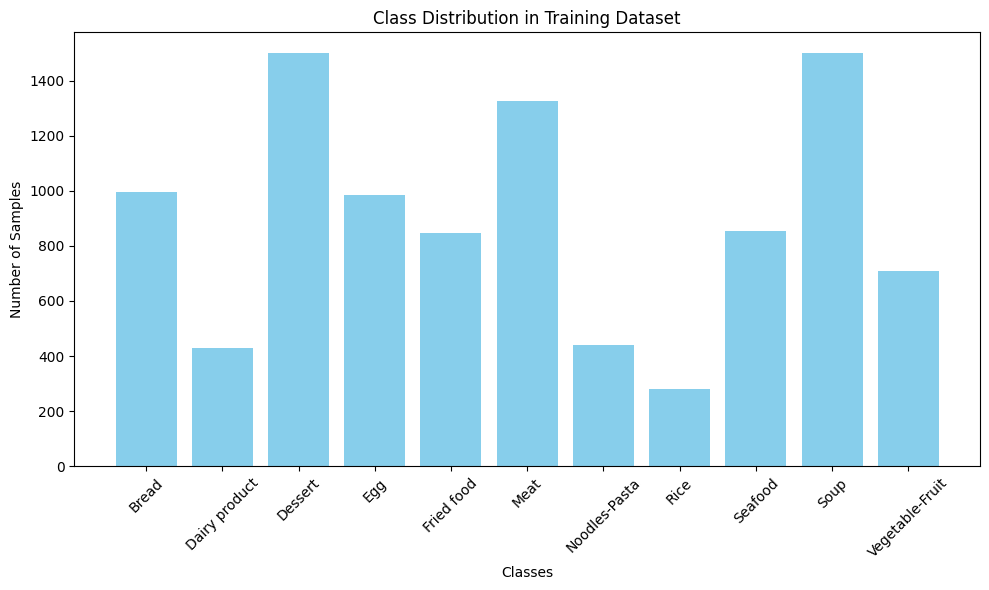

In [64]:
from collections import Counter

class_counts = Counter(train_dataset.targets)

class_names = train_dataset.classes

class_distribution = {class_names[i]: count for i, count in class_counts.items()}

# 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
from torch.utils.data import WeightedRandomSampler

# 클래스별 샘플 수를 계산하는 함수
def count_class_samples(targets, num_classes):
    class_counts = Counter(targets)
    return [class_counts[i] for i in range(num_classes)]

# 멀티프로세싱을 사용하여 샘플 가중치 계산
def calculate_sample_weights(targets, num_classes):
    from multiprocessing import Pool, cpu_count
    with Pool(cpu_count()) as pool:
        class_counts = pool.apply(count_class_samples, (targets, num_classes))

    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = [class_weights[label] for label in targets]
    return sample_weights

# 데이터셋에 대해 클래스별 샘플 수를 계산하고 가중치 생성
targets = train_dataset.targets 
num_classes = len(set(targets))
sample_weights = calculate_sample_weights(targets, num_classes)

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

print("INFO: Sample weights and sampler created successfully.")

## Custom DataLoader

###### Custom DataLoader는 과도한 데이터 변형으로 인한 불안정성을 피하기 위해 배치 전체에 기본 증강, CutMix, MixUp을 서로 다른 비율로 적용하는 방식을 구현한다.

###### CutMix와 MixUp 기법을 추가함으로써 데이터의 다양성을 높여 과적합을 방지하고, 일반화 성능을 향상시킬 수 있다.

###### 특히, 기존 방식대로 기본 데이터 증강, CutMix, MixUp을 전체 배치에 동일하게 적용하는 대신, 각각을 서로 다른 비율로 적용하여 차별화를 두었다. 이를 통해 기본 증강 데이터로 이미지의 주요 특성을 유지하면서, CutMix와 MixUp을 통해 한층 더 변형된 데이터를 학습할 수 있도록 한다. 이로써 과적합 방지와 학습 안정성 사이에서 균형을 이룰 수 있다.

###### 또한, 학습 초기에는 기본 증강 데이터의 비율을 50% 이상으로 설정해 안정적인 수렴을 도모하고, 학습 후반에는 CutMix와 MixUp의 정규화 효과를 극대화하여 추가적인 성능 향상을 도모할 수 있도록 설계하였다.

In [ ]:
class CustomDatasetLoader(DataLoader):
    def __init__(self, *args, sampler=None, use_cutmix=False, use_mixup=False, alpha=1.0,
                 base_augment_ratio=0.5, cutmix_ratio=0.25, mixup_ratio=0.25, **kwargs):
        super().__init__(*args, sampler=sampler, **kwargs)
        self.use_cutmix = use_cutmix
        self.use_mixup = use_mixup
        self.alpha = alpha

        # 각 증강 비율을 지정
        self.base_augment_ratio = base_augment_ratio
        self.cutmix_ratio = cutmix_ratio
        self.mixup_ratio = mixup_ratio

        # 비율의 합이 1.0인지 확인 (오차 허용 범위는 1e-6)
        assert abs(base_augment_ratio + cutmix_ratio + mixup_ratio - 1.0) < 1e-6, \
            "base_augment_ratio, cutmix_ratio, mixup_ratio의 합은 1이어야 합니다."

    def __iter__(self):
        for batch in super().__iter__():
            x, y = batch
            batch_size = x.size(0)

            # 배치에서 각 비율에 맞게 나누기
            base_augment_size = int(self.base_augment_ratio * batch_size)
            cutmix_size = int(self.cutmix_ratio * batch_size)
            mixup_size = int(self.mixup_ratio * batch_size)

            # 배치 사이즈와 비율로 인해 발생하는 나머지를 처리
            remainder = batch_size - (base_augment_size + cutmix_size + mixup_size)

            x_base = x[:base_augment_size]
            y_base = y[:base_augment_size]

            x_mixup, y_a_mixup, y_b_mixup, lam_mixup = x[base_augment_size:base_augment_size+mixup_size], \
                y[base_augment_size:base_augment_size+mixup_size], \
                y[base_augment_size:base_augment_size+mixup_size], 1.0
            if self.use_mixup:
                x_mixup, y_a_mixup, y_b_mixup, lam_mixup = mixup(x_mixup, y_a_mixup, self.alpha)

            x_cutmix, y_a_cutmix, y_b_cutmix, lam_cutmix = x[base_augment_size+mixup_size:base_augment_size+mixup_size+cutmix_size], \
                y[base_augment_size+mixup_size:base_augment_size+mixup_size+cutmix_size], \
                y[base_augment_size+mixup_size:base_augment_size+mixup_size+cutmix_size], 1.0
            if self.use_cutmix:
                x_cutmix, y_a_cutmix, y_b_cutmix, lam_cutmix = cutmix(x_cutmix, y_a_cutmix, self.alpha)

            # 나머지 처리를 기본 증강 데이터에 추가
            if remainder > 0:
                x_extra = x[-remainder:]
                y_extra = y[-remainder:]
                x_base = torch.cat((x_base, x_extra), dim=0)
                y_base = torch.cat((y_base, y_extra), dim=0)

            # 최종 배치 구성
            x_final = torch.cat((x_base, x_mixup, x_cutmix), dim=0)
            y_final = torch.cat((y_base, y_a_mixup, y_a_cutmix), dim=0)
            y_final_b = torch.cat((y_base, y_b_mixup, y_b_cutmix), dim=0)

            # 최종 배치를 반환, lam 값도 반환하여 사용자가 관리할 수 있게 함
            yield x_final, y_final, y_final_b, lam_mixup, lam_cutmix

In [ ]:
# Multi-processing 설정
MULTI_PROCESSING = True # 문제가 발생하면 False로 설정

from platform import system
if MULTI_PROCESSING and system() != "Windows": # 윈도우에선 멀티프로세싱을 지원하지 않음
    import multiprocessing
    cpu_cores = max(1, multiprocessing.cpu_count() // 4) # CPU 코어 수의 1/4만 사용
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader with minimum processing.")

In [ ]:
# CustomDatasetLoader 사용
train_loader = CustomDatasetLoader(
    train_dataset,
    batch_size=BATCH_SIZE, # 배치 사이즈 설정
    sampler=sampler,  # WeightedRandomSampler를 사용하여 불균형 데이터 처리
    num_workers=cpu_cores, # 멀티프로세싱 사용
    use_cutmix=True, # CutMix 사용
    use_mixup=True, # MixUp 사용
    alpha=1.0, # Mixup 및 CutMix의 알파 값
    base_augment_ratio=0.5, # 기본 증강 비율
    cutmix_ratio=0.25, # CutMix 비율
    mixup_ratio=0.25 # MixUp 비율
)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

In [ ]:
# 이미지 시각화
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = image_list.numpy().transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)
    plt.axis('off')
    plt.show()

In [ ]:
# 데이터 로더에서 이미지를 가져옴
data = next(iter(train_loader))

# 데이터가 4개일 경우 (일반 배치)
if len(data) == 4:
    images, targets = data[:2]  # 일반 배치 처리 (이미지와 타겟)

# 데이터가 5개일 경우 (MixUp 또는 CutMix 배치)
elif len(data) == 5:
    images, targets_a, targets_b, lam_mixup, lam_cutmix = data  # MixUp 또는 CutMix 처리

In [ ]:
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=20)
imshow(grid_images)

## Define Model

##### 초기 시도 : ResNet50 모델 약 81%성능 달성

##### 후기 시도 : ResNeXt50_32x4d 약 86% 성능 달성 -> ResNeXt101_32x8d 약 88% 성능 달성 -> ResNeXt101_32x8d + SEBlock : 약 90.5% 성능달성

##### ResNeXt: ResNet에 병렬 경로를 추가해 성능을 개선한 모델, 카디널리티 개념을 도입하여 적은 파라미터로도 더 강력한 성능을 발휘.

##### SEBlock: 기존 CNN은 채널 간의 상관관계를 충분히 고려하지 못하는 한계가 있음. SEBlock을 도입함으로써 각 채널이 얼마나 중요한지 동적으로 학습하여, 네트워크의 성능을 높임

##### 이미지 크기가 512x512임을 고려하여, Self-attention보다 상대적으로 단순한 연산을 사용하는 SEBlock을 도입함으로써 메모리 사용량은 절약하면서도 모델의 성능을 향상시킬 수 있었음.

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

In [ ]:
class ResNeXtBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, cardinality=32, base_width=4, reduction=16):
        super(ResNeXtBottleneck, self).__init__()
        width = int(planes * (base_width / 64.)) * cardinality
        # 1x1 Conv
        self.conv1 = nn.Conv2d(in_planes, width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        # 3x3 Grouped Conv
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        # 1x1 Conv
        self.conv3 = nn.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # SEBlock 추가
        self.se = SEBlock(planes * self.expansion, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = nn.functional.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)  # SEBlock 적용
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out

In [ ]:
class ResNeXt(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, cardinality=32, base_width=4):
        super(ResNeXt, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, cardinality=cardinality, base_width=base_width)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, cardinality=cardinality, base_width=base_width)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, cardinality=cardinality, base_width=base_width)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, cardinality=cardinality, base_width=base_width)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, cardinality, base_width):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, cardinality, base_width))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
def ResNeXt50_32x4d(num_classes=1000):
    return ResNeXt(ResNeXtBottleneck, [3, 4, 6, 3], num_classes=num_classes, cardinality=32, base_width=4)

def ResNeXt101_32x8d(num_classes=1000):
    return ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], num_classes=num_classes, cardinality=32, base_width=8)

In [ ]:
# 모델 초기화
model = ResNeXt101_32x8d()
model_id = "ResNeXt101_32x8d"

# 다중 GPU 설정 (DataParallel 사용)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# 모델을 장치로 이동
model.to(device)

In [ ]:
LEARNING_RATE = 0.0003 # 학습률 설정
WEIGHT_DECAY = 1e-5 # 가중치 감쇠, 과적합을 방지하기 위해 가중치에 페널티를 부여

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss를 손실함수로 사용
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # AdamW 옵티마이저 사용, L2 정규화(weight_decay) 적용
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100) # 학습률 스케줄러, Cosine Annealing으로 학습률을 점진적으로 줄임 (T_max: 주기)

## Training Loop

In [ ]:
# 모델 저장 및 불러오는 함수 정의
def save_checkpoint(epoch, model, optimizer, loss, PATH):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, PATH)
    print(f" Model saved.")

def load_checkpoint(PATH, model, optimizer):
    if path.isfile(PATH):
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        print(f"체크포인트 '{path.basename(PATH)}'에서 모델 로드 완료 (시작 에포크: {start_epoch})")
        return start_epoch, loss
    else:
        print(f"체크포인트 '{path.basename(PATH)}'를 찾을 수 없습니다. 새로 훈련을 시작합니다.")
        return 0, None

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# 인터랙티브 손실 그래프 업데이트
def create_plot():
    train_losses = []
    valid_losses = []

    # 인터랙티브 모드 활성화
    plt.ion()

    # 손실 그래프 설정
    fig, ax = plt.subplots(figsize=(6, 4))
    train_line, = ax.plot(train_losses, label="Train Loss")
    valid_line, = ax.plot(valid_losses, label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")
    ax.legend()

    # 그래프 출력
    plot = widgets.Output()
    display(plot)

    def update_plot(epoch, train_loss=None, valid_loss=None):
        if train_loss is not None:
            train_losses.append(train_loss)
            train_line.set_ydata(train_losses)
            train_line.set_xdata(range(1, len(train_losses) + 1))

        if valid_loss is not None:
            valid_losses.append(valid_loss)
            valid_line.set_ydata(valid_losses)
            valid_line.set_xdata(range(1, len(valid_losses) + 1))

        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [ ]:
# 조기 종료(early stopping) 정의
def early_stopping(val_loss, best_val_loss, patience_counter, patience, model, epoch, optimizer, checkpoint_path):

    stop_training = False

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_checkpoint(epoch, model, optimizer, val_loss, checkpoint_path)  # 최상의 모델 저장
    else:
        patience_counter += 1

    if patience_counter >= patience:
        stop_training = True

    return best_val_loss, patience_counter, stop_training

## process_batch define

###### CutMix와 MixUp과 같은 데이터 증강 기법이 적용된 다양한 배치 형태를 처리하는 역할
###### 배치의 길이에 따라 적절히 데이터를 나누고, 각각의 증강 기법에 맞는 방식으로 손실(loss)을 계산
###### 기본 배치(2개 요소)에서는 일반적인 손실 계산을, CutMix/MixUp이 적용된 배치(4개 또는 5개 요소)에서는 가중치가 적용된 손실 계산을 수행

In [ ]:
def process_batch(batch, model, criterion, device):
    if len(batch) == 4:  # CutMix 또는 MixUp이 적용된 경우
        inputs, targets_a, targets_b, lam = batch
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
    elif len(batch) == 5:  # CutMix와 MixUp 둘 다 적용된 경우
        inputs, targets_a, targets_b, lam_mixup, lam_cutmix = batch
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
        outputs = model(inputs)
        loss_mixup = lam_mixup * criterion(outputs, targets_a) + (1 - lam_mixup) * criterion(outputs, targets_b)
        loss_cutmix = lam_cutmix * criterion(outputs, targets_a) + (1 - lam_cutmix) * criterion(outputs, targets_b)
        loss = (loss_mixup + loss_cutmix) / 2
    elif len(batch) == 2:  # CutMix 또는 MixUp이 적용되지 않은 경우
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
    else:
        raise ValueError(f"Unexpected number of elements in batch: {len(batch)}")

    return loss

In [ ]:
# Epoch 수 설정
num_epochs = 200

In [ ]:
# Mixed Precision Training을 위한 GradScaler 생성
scaler = GradScaler()

# Early Stopping 설정
early_stopping_patience = 20  # 개선되지 않은 loss에 대해 기다릴 최대 epoch 수
best_val_loss = np.inf
patience_counter = 0

# 해당 경로에 폴더가 없을 경우 폴더 생성
makedirs('checkpoints', exist_ok=True)
makedirs(path.join('checkpoints', 'early_stopping'), exist_ok=True)

PATH = path.join('checkpoints', f"{model_id}_checkpoint.pt.tar") # 모델 체크포인트 저장 경로
early_stopping_PATH = os.path.join('checkpoints', 'early_stopping', f"{model_id}_checkpoint.pt.tar") # 조기 종료 모델 저장 경로
save_cycle = 5 # 모델 저장 주기 설정

# 체크포인트 로드
start_epoch, _ = load_checkpoint(PATH, model, optimizer)

# 훈련 및 검증 루프 설정
train_length, valid_length = map(len, (train_loader, valid_loader))

# 전체 학습 과정의 진행 상황을 tqdm로 시각화
epochs = tqdm(range(start_epoch, num_epochs), desc="Epochs", position=0)
training_bar = tqdm(total=train_length, desc="Training", position=1, leave=True)
validation_bar = tqdm(total=valid_length, desc="Validation", position=2, leave=True)
update = create_plot()  # 손실 그래프 생성 (실시간 업데이트)

for epoch in epochs:
    training_bar.reset(total=train_length)
    validation_bar.reset(total=valid_length)

    # 훈련
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # AMP(혼합 정밀도) 사용 : 16비트와 32비트 부동소수점 연산을 혼합해 연산 속도와 메모리 효율을 향상
            loss = process_batch(batch, model, criterion, device)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item()
        training_bar.update(1)
        print(f"\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{train_length}], Loss: {loss.item():.6f}", end="")

    avg_train_loss = running_train_loss / train_length

    val_acc, val_loss = 0, 0

    # 검증
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            with torch.cuda.amp.autocast():
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum().item()

            validation_bar.update(1)

    val_acc /= len(valid_dataset)
    print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % save_cycle == 0 or (epoch+1) == num_epochs else "")

    # 평균 학습 손실 및 검증 손실로 그래프 업데이트
    update(epoch + 1, train_loss=avg_train_loss, valid_loss=val_loss)

    # 종기 종료 기준 확인
    best_val_loss, patience_counter, stop_training = early_stopping(
        val_loss, best_val_loss, patience_counter, early_stopping_patience, model, epoch, optimizer, early_stopping_PATH
    )

    if stop_training:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # save_cycle마다 모델 저장
    if (epoch + 1) % save_cycle == 0:
        save_checkpoint(epoch, model, optimizer, loss.item(), PATH)

print("Training Completed!")

![Loss Plot](./images/loss_plot.png)

In [ ]:
if not path.isdir(path.join(".", "models")):
    mkdir(path.join(".", "models"))

# 모델 저장
save_path = path.join(".", "models", f"{model_id}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# 모델 로드
model = ResNeXt101_32x8d()

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label'] += [train_dataset.classes[i] for i in preds.cpu().detach().numpy().tolist()]

In [ ]:
# 결과 저장
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()

In [ ]:
# 학습 종료 시 GPU 메모리 해제
torch.cuda.empty_cache()

# 현재 프로세스 PID를 가져와 종료
pid = os.getpid()
os.kill(pid, signal.SIGKILL)